In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from pprint import pprint
import glob
import networkx as nx
import main_v2 
import matplotlib.pyplot as plt
import seaborn as sns
from main_v2 import node_record
from main_v2 import node_entity


In [33]:
df, labelled_indices, g, record_nodeID_dict, domain_entity_nodeID_dict = main_v2.preprocess_1(False)
print(g.number_of_nodes(), g.number_of_edges())

['PanjivaRecordID', 'CustomsCode', 'LocationCode', 'PortOfUnladingUNLOCODE', 'ShipmentDestination', 'ShipperPanjivaID', 'TransportMethod', 'hscode_6']
46346 330639


In [34]:
# lets try to remove the  feature -feature edges
_edges = list(g.edges())
for e in _edges:
    n1t = g.nodes[e[0]]['data'].type
    n2t = g.nodes[e[1]]['data'].type
    if n1t =='entity' and n2t == 'entity':
        g.remove_edge(e[0],e[1])

In [35]:
g.number_of_edges()

312949

In [36]:


# new labels
Y_new = main_v2.semi_supervised(
    g,
    labelled_indices
)

(46346, 46346)
iter : 0  |  diff : 0.001868085379511604
 difference =  1.5980609644828184e-08
 Number of iterations  4


In [37]:
_list = []
for i in range(Y_new.shape[0]):
    if abs(Y_new[i]) >= 0.001:
        _list.append(i)

In [38]:
import math 
from sklearn.preprocessing import MinMaxScaler

def _scale_values(arr):
    scale = lambda x: math.exp(abs(x)) * math.copysign(1, x) 
    tmp = np.reshape(arr,[-1])
    tmp = list(tmp)
    tmp = [scale(_) for _ in tmp]
    scaler = MinMaxScaler([-1,1])
    tmp = scaler.fit_transform(np.reshape(tmp,[-1,1]))
    return tmp


In [39]:
def number_of_label_changes(Y_old,Y_new):
    tmp1 = np.reshape(Y_old,[-1])
    tmp2 = np.reshape(Y_new,[-1])
    _sign_change = 0
    _non_zero = 0
    for a,b in zip(tmp1,tmp2):
        if (a < 0 and b > 0) or  (a > 0 and b < 0):
            _sign_change += 1
        elif (a == 0 and b!=0) or ( a != 0 and b == 0):
            _non_zero +=1
    print(_sign_change, _non_zero, _sign_change+_non_zero)
    return


In [40]:
Y_orig = labelled_indices

In [41]:
Y_new = main_v2.semi_supervised(
    g,
    Y_orig
)

number_of_loops = range(1)
Y_old = np.array(Y_orig)
for n in number_of_loops:
    Y_new = main_v2.semi_supervised(
        g,
        Y_old
    )
    number_of_label_changes(Y_old,Y_new)
#     if n ==0 :
#         Y_new = _scale_values(Y_new)
    Y_old = Y_new

(46346, 46346)
iter : 0  |  diff : 0.001868085379511604
 difference =  1.5980609644828184e-08
 Number of iterations  4
(46346, 46346)
iter : 0  |  diff : 0.001868085379511604
 difference =  1.5980609644828184e-08
 Number of iterations  4
0 46094 46094


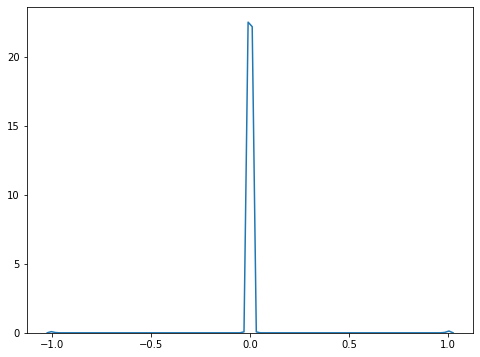

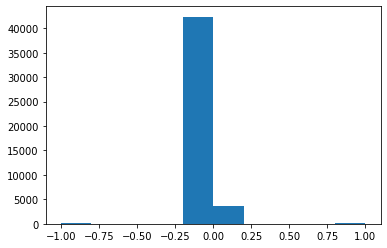

In [42]:
plt.figure(figsize=[8,6])
tmp =np.reshape(Y_old,[-1])
sns.kdeplot(tmp)

plt.show()
plt.hist(tmp)
plt.show()

In [43]:
from IPython.display import display, HTML

def show_row(df,P_id):
    _df = df.loc[df['PanjivaRecordID'] == P_id]
    display(HTML(_df.to_html()))
    return


# Let us see if the most positive rows are "similar to" the ones in the anomalies

In [44]:
nodeID_record_dict = {v:k for k,v  in record_nodeID_dict.items()}

def get_similar_Pids (
    Y_cur, 
    nodeID_record_dict
):
    _list = []
    _dict = {}
    _tmp = _scale_values(Y_cur)
    for i in range(Y_cur.shape[0]):
        if _tmp[i][0] < 1.0 and _tmp[i][0] > 0.35 :
            if  i in nodeID_record_dict.keys():
                _list.append(nodeID_record_dict[i])
                _dict[nodeID_record_dict[i]] = _tmp[i][0]
    print(len(_list))
    import operator
    
    sorted_scores = sorted(_dict.items(), key=operator.itemgetter(1) , reverse=True )
    
    return _list, sorted_scores


In [45]:
_list, sorted_scores = get_similar_Pids (Y_old, nodeID_record_dict)

2375


In [46]:
for s in sorted_scores[:10]:
    s1 = record_nodeID_dict[s[0]]
    s2 = s[1]
    print(s1,s2)
    
    # find the neighbors & show their weights
    obj = g.nodes[s1]['data']
    
    for nbr in g.neighbors(s1):
        e = g.get_edge_data(s1,nbr)['weight']
        print(Y_old[nbr],e,g.nodes[nbr]['data'].domain)
    print('-----')

10937 0.36787956341242384
[-0.] 0.012347059744559017 CustomsCode
[-0.] 0.0028854541794349877 LocationCode
[-1.525e-10] 8.947144742434071e-05 PortOfUnladingUNLOCODE
[-0.001] 0.01248126691569553 ShipmentDestination
[-0.001] 0.005502494016596953 ShipperPanjivaID
[0.] 0.09110430133983492 TransportMethod
[-0.001] 0.005636701187733464 hscode_6
-----
43392 0.36787956341242384
[-0.] 0.012347059744559017 CustomsCode
[-0.] 0.0028854541794349877 LocationCode
[-1.525e-10] 8.947144742434071e-05 PortOfUnladingUNLOCODE
[-0.001] 0.01248126691569553 ShipmentDestination
[-0.001] 0.005502494016596953 ShipperPanjivaID
[0.] 0.09110430133983492 TransportMethod
[-0.001] 0.005636701187733464 hscode_6
-----
43653 0.36787956341242384
[-0.] 0.012347059744559017 CustomsCode
[-0.] 0.0028854541794349877 LocationCode
[-1.525e-10] 8.947144742434071e-05 PortOfUnladingUNLOCODE
[-0.001] 0.01248126691569553 ShipmentDestination
[-0.001] 0.005502494016596953 ShipperPanjivaID
[0.] 0.09110430133983492 TransportMethod
[-0.001